In [11]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import joblib

DATA_DIR = Path("Data")

In [12]:
def prepare_dataset(kind: str):
    if kind == "fourier":
        X_df = pd.read_csv(DATA_DIR / "X" / "X_fourier_processed.csv")
    elif kind == "metrics":
        X_df = pd.read_csv(DATA_DIR / "X" / "X_metrics_processed.csv")
    else:
        raise ValueError("kind debe ser 'fourier' o 'metrics'")

    Y_df = pd.read_csv(DATA_DIR / "Y" / "Y.csv")

    data = X_df.merge(
        Y_df[[
            "filename", "VehId", "DayNum", "Trip",
            "Y_consumption_combustion_L_per_100km",
            "Y_consumption_electric_kWh_per_km"
        ]],
        on=["filename", "VehId", "DayNum", "Trip"],
        how="inner"
    )

    exclude_cols = [
        "filename", "DayNum", "Trip", "Timestamp", "Timestamp(ms)",
        "Y_consumption_combustion_L_per_100km",
        "Y_consumption_electric_kWh_per_km"
    ]

    feature_cols = [
        col for col in data.columns
        if col not in exclude_cols
        and col != "VehId"
        and col != "filename"
        and data[col].dtype in [np.float64, np.int64]
    ]

    X = data[feature_cols].fillna(data[feature_cols].mean())
    target_col = "Y_consumption_combustion_L_per_100km"
    y = data[target_col].fillna(data[target_col].mean()).values

    indices = np.arange(len(X))

    idx_dev, idx_test, X_dev, X_test, y_dev, y_test = train_test_split(
        indices, X, y, test_size=0.2, random_state=69
    )

    idx_train, idx_val, X_train, X_val, y_train, y_val = train_test_split(
        idx_dev, X_dev, y_dev, test_size=0.2, random_state=69
    )

    ids_test = data.loc[idx_test, ["filename", "VehId", "DayNum", "Trip"]].reset_index(drop=True)

    # Return unsanitized test data - scalers from notebooks 2&3 expect unsanitized column names
    # X_test will be used with the saved scalers that were fit on unsanitized column names
    return X_test, y_test, ids_test


In [13]:
X_fourier_test, y_test_fourier, ids_fourier = prepare_dataset("fourier")
X_metrics_test, y_test_metrics, ids_metrics = prepare_dataset("metrics")

print("Fourier test shape:", X_fourier_test.shape)
print("Metrics test shape:", X_metrics_test.shape)

y_test = y_test_fourier

# Cargar los mejores modelos y sus escalers
print("\nCargando modelos...")
best_fourier = joblib.load("models/saved_models/fourier/best_model.pkl")
scaler_fourier = joblib.load("models/saved_models/fourier/scaler.pkl")
print("✓ Fourier best model cargado")

best_metrics = joblib.load("models/saved_models/metrics/best_model.pkl")
scaler_metrics = joblib.load("models/saved_models/metrics/scaler.pkl")
print("✓ Metrics best model cargado")

# Sanitize column names function (remove brackets and special chars for model compatibility)
def sanitize_columns(df):
    """Remove brackets and special chars from column names to match model training"""
    df_copy = df.copy()
    df_copy.columns = [
        col.replace('[', '').replace(']', '').replace('<', '').replace('>', '')
        for col in df_copy.columns
    ]
    return df_copy

# Step 1: Scale the data (scaler expects original column names with brackets)
X_fourier_test_scaled = pd.DataFrame(
    scaler_fourier.transform(X_fourier_test),
    columns=X_fourier_test.columns,
    index=X_fourier_test.index
)

X_metrics_test_scaled = pd.DataFrame(
    scaler_metrics.transform(X_metrics_test),
    columns=X_metrics_test.columns,
    index=X_metrics_test.index
)

# Step 2: Sanitize column names for model (model expects sanitized names without brackets)
X_fourier_test_scaled = sanitize_columns(X_fourier_test_scaled)
X_metrics_test_scaled = sanitize_columns(X_metrics_test_scaled)

# Step 3: Predict
pred_fourier = best_fourier.predict(X_fourier_test_scaled)
pred_metrics = best_metrics.predict(X_metrics_test_scaled)

print("\n✓ Predicciones completadas")

C:\Users\nalli\AppData\Local\Temp\ipykernel_1000\597500191.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  X_df = pd.read_csv(DATA_DIR / "X" / "X_fourier_processed.csv")
C:\Users\nalli\AppData\Local\Temp\ipykernel_1000\597500191.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  X_df = pd.read_csv(DATA_DIR / "X" / "X_metrics_processed.csv")
C:\Users\nalli\AppData\Local\Temp\ipykernel_1000\597500191.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  X_df = pd.read_csv(DATA_DIR / "X" / "X_metrics_processed.csv")


Fourier test shape: (6509, 158)
Metrics test shape: (6509, 106)

Cargando modelos...
✓ Fourier best model cargado
✓ Metrics best model cargado

✓ Predicciones completadas


,Model,MSE,MAE,R2
0,Best (Fourier),0.209896,0.057841,0.809943
1,Best (Metrics),0.068606,0.021103,0.937878



MEJOR MODELO GENERAL: Metrics


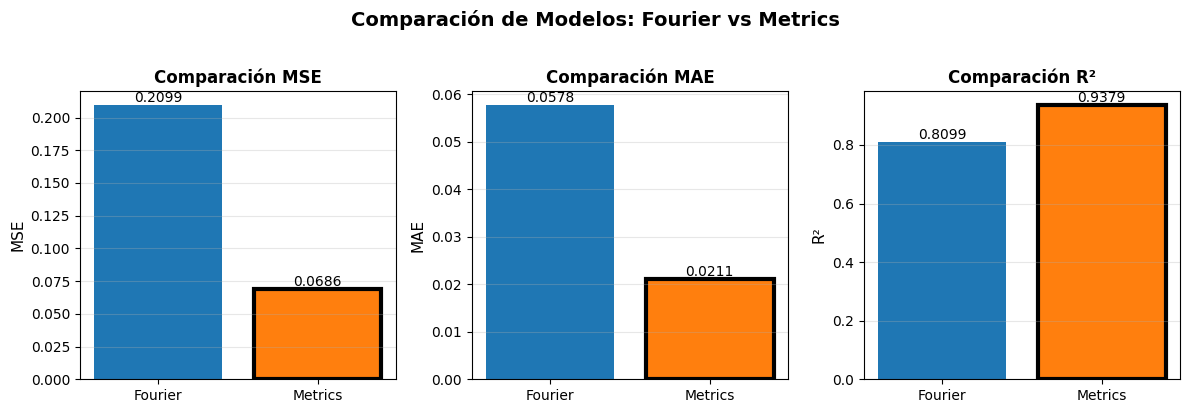


Detalles de la Comparación:
  Fourier - MSE: 0.209896, MAE: 0.057841, R²: 0.809943
  Metrics - MSE: 0.068606, MAE: 0.021103, R²: 0.937878


In [19]:
# Métricas de los modelos
mse_fourier = mean_squared_error(y_test, pred_fourier)
mse_metrics = mean_squared_error(y_test, pred_metrics)

mae_fourier = mean_absolute_error(y_test, pred_fourier)
mae_metrics = mean_absolute_error(y_test, pred_metrics)

r2_fourier = r2_score(y_test, pred_fourier)
r2_metrics = r2_score(y_test, pred_metrics)

results = {
    "Model": ["Best (Fourier)", "Best (Metrics)"],
    "MSE": [mse_fourier, mse_metrics],
    "MAE": [mae_fourier, mae_metrics],
    "R2": [r2_fourier, r2_metrics],
}

df_results = pd.DataFrame(results)
display(df_results)

# Determinar mejor modelo
best_overall = "Fourier" if r2_fourier > r2_metrics else "Metrics"
print(f"\n{'='*60}")
print(f"MEJOR MODELO GENERAL: {best_overall}")
print(f"{'='*60}")

# Gráfico de comparación
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

model_names = ["Fourier", "Metrics"]
colors = ['#1f77b4', '#ff7f0e']

metrics_list = ["MSE", "MAE", "R²"]
values_all = [
    [mse_fourier, mse_metrics],
    [mae_fourier, mae_metrics],
    [r2_fourier, r2_metrics]
]

for idx, (metric, values) in enumerate(zip(metrics_list, values_all)):
    ax = axes[idx]
    bars = ax.bar(model_names, values, color=colors)
    
    # Resaltar el mejor modelo
    if metric == "R²":
        best_idx = 0 if r2_fourier > r2_metrics else 1
    else:
        best_idx = 0 if values[0] < values[1] else 1
    
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(3)
    
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f"Comparación {metric}", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.suptitle('Comparación de Modelos: Fourier vs Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nDetalles de la Comparación:")
print(f"  Fourier - MSE: {mse_fourier:.6f}, MAE: {mae_fourier:.6f}, R²: {r2_fourier:.6f}")
print(f"  Metrics - MSE: {mse_metrics:.6f}, MAE: {mae_metrics:.6f}, R²: {r2_metrics:.6f}")